<a href="https://colab.research.google.com/github/ryuqae/2022-meta-learning/blob/main/Clickbait_Detection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U sentence-transformers

import pandas as pd
import sys, os
import numpy as np


import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer, Trainer
from transformers import DistilBertTokenizer, DistilBertModel

from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import logging
from tqdm.auto import tqdm
from pprint import pprint
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    )
logger = logging.getLogger(__name__)


GPU_NUM = 0

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('\n==================== \nCurrent cuda device ', torch.cuda.current_device()) # check

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Current cuda device  0


/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

DATA_DIR = '/content/drive/MyDrive/kaggle_clickbait'
# DATA_DIR = '/content/drive/MyDrive/Meta Learning/kaggle_clickbait'

train_valid = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col='id').dropna()
train = train_valid.sample(frac=0.8)
valid = train_valid.drop(train.index)

test = pd.read_csv(os.path.join(DATA_DIR, 'valid.csv'), index_col='id').dropna()

train = train[train.label!='other'].reset_index()
valid = valid[valid.label!='other'].reset_index()
test = test[test.label!='other'].reset_index()

train.shape, valid.shape, test.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((14651, 4), (3679, 4), (2624, 4))

In [ ]:
valid.groupby('label').sample(1)

,id,title,text,label
2,16,Destinations Inside North Korea: fascinating images of the world's most secretive state,"03 Apr 2017 Mark Edward Harris has visited North Korea a remarkable 10 times and has seen many changes to the country since his first trip, largely positive. ""In spite of the economic weight of international embargos, the once barren streets are now full of cars, including taxis, in Pyongyang,"" he said. ""Economic growth seems to be slowly trickling out to cities and towns beyond the capital."" Here he chooses 17 of his favourite images taken during his time in North Korea. Harris's latest book, ""North Korea,"" was named Photography Book of the Year at the International Photography Awards. His other books include ""South Korea,"" ""Inside Iran,"" ""Wanderlust,"" and ""The Way of the Japanese Bath."" See www.MarkEdwardHarris.com The Joint Security Area (JSA) in 2014, as seen from the North Korean side at Panmunjeom, looking across the Military Demarcation Line (MDL) to the South Korean side. In 1997 I was one of those visitors gazing across the no man's land that divides North and South Korea...",clickbait
2869,14540,"David Sweat and Richard Matt, Escaped Inmates, ‘Will Do Whatever It Takes,’ Governor Warns","The governor of Vermont issued a stark warning to the public on Thursday that the two killers who escaped from a maximum-security New York prison ""will do whatever it takes"" to stay free. ""If that means harming you, that won't bother them much,"" Gov. Peter Shumlin said. ""So obviously do not get near them."" Authorities said Wednesday they had reason to believe the escapees, Richard Matt and David Sweat, might have headed for Vermont. The prison, Clinton Correctional Facility in Dannemora, is not far from Lake Champlain, which separates New York from Vermont. Shumlin said he had no information on exactly where in Vermont the fugitives might be, but he warned people to look out for stolen boats and canoes. ""These are not nice guys. They kill. They maim,"" the governor said. ""They'll do anything, they'll steal anything to try to remain free."" ""The more time passes,"" he said, ""the more desperate they tend to get."" An earlier tip that the killers might be on Burton Island, on the lake, di...",news


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [ ]:
class ClickbaitDataset(Dataset):
    def __init__(self,
                 headlines:list, 
                 texts:list,
                 concat_mode:str='cosine_similarity',
                 labels:list=None, 
                 label_dict: dict =None,
                 max_seq_length: int=64,
                 device=device,
                 num_body_sents:int=64,
                 model_name: str='distilbert-base-uncased'):
        
        self.headlines = headlines
        self.texts = texts
        self.concat_mode = concat_mode
        self.labels = labels
        self.num_body_sents= num_body_sents
        self.label_dict = label_dict
        self.head_model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)
        self.body_model = SentenceTransformer("stsb-distilbert-base", device=device)


        if self.label_dict is None and labels is not None:
            # {'clickbait': 0, 'news': 1, 'other': 2}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))


        self.max_seq_length=max_seq_length
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.sep_vid = self.tokenizer.vocab["[SEP]"]
        self.cls_vid = self.tokenizer.vocab["[CLS]"]
        self.pad_vid = self.tokenizer.vocab["[PAD]"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):

        # Headline
        x_head = self.headlines[index]
        x_head_encoded = self.tokenizer.encode(x_head, add_special_tokens=True, 
                                        truncation=True, 
                                        max_length=self.max_seq_length, 
                                        return_tensors="pt").squeeze(0)

        x_head_encoded_length = x_head_encoded.size(0)


        # Body Text
        body = self.texts[index]
        body_sents =  np.random.choice(sent_tokenize(str(body)), size=self.num_body_sents, replace=True)

        # Manually Padding...
        head_pad_size = self.max_seq_length - x_head_encoded_length
        head_pad_ids = torch.Tensor([self.pad_vid] * head_pad_size).long()
        x_head_tensor = torch.cat((x_head_encoded, head_pad_ids))

        # Manually Masking...
        head_mask = torch.ones_like(x_head_encoded, dtype=torch.int8)
        head_mask_pad = torch.zeros_like(head_pad_ids, dtype=torch.int8)
        head_mask = torch.cat((head_mask, head_mask_pad), dim=0)

        head_input = {"input_ids" : x_head_tensor.long().unsqueeze(0).to(device), "attention_mask": head_mask.long().unsqueeze(0).to(device),}

        with torch.no_grad():
            head_encoded = self.head_model(**head_input)[0].squeeze(0)
            body_encoded = self.body_model.encode(body_sents, convert_to_tensor=True, show_progress_bar=False)

        output_dict = {"head_encoded" : head_encoded, "head_mask": head_mask, "body_encoded": body_encoded}

        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict['labels'] = y_encoded

        return output_dict
    

In [ ]:
MODEL_NAME = 'distilbert-base-uncased' # pretrained model from Transformers
LOG_DIR = "./logdir"                   # for training logs and tensorboard visualizations
NUM_EPOCHS = 10                         # smth around 2-6 epochs is typically fine when finetuning transformers
BATCH_SIZE = 2048                        # depends on your available GPU memory (in combination with max seq length)
MAX_HEAD_LENGTH = 32                   # depends on your available GPU memory (in combination with batch size)
NUM_CLASSES = 2                        # solving 3-class classification problem
LEARN_RATE = 1e-4                      # learning rate is typically ~1e-5 for transformers
ACCUM_STEPS = 4                        # one optimization step for that many backward passes
SEED = 17
NUM_SENTENCES = 32

train_dataset = ClickbaitDataset(texts = train["text"], 
                                 headlines = train["title"], 
                                 labels=train['label'], 
                                 label_dict=None, 
                                 max_seq_length=MAX_HEAD_LENGTH,
                                 num_body_sents=NUM_SENTENCES)

valid_dataset = ClickbaitDataset(texts = valid["text"], 
                                 headlines = valid["title"], 
                                 labels=valid['label'], 
                                 label_dict=train_dataset.label_dict,
                                 max_seq_length=MAX_HEAD_LENGTH,
                                 num_body_sents=NUM_SENTENCES)

test_dataset = ClickbaitDataset(texts = test["text"], 
                                headlines = test["title"], 
                                labels=test['label'], 
                                label_dict=train_dataset.label_dict,
                                max_seq_length=MAX_HEAD_LENGTH,
                                num_body_sents=NUM_SENTENCES)

train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

valid_dataloader = DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2022-06-23 12:09:53 - Load pretrained SentenceTransformer: stsb-distilbert-base
/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading 

In [ ]:
class ClickbaitDetector(nn.Module):
    def __init__(self, head_model_name='distilbert-base-uncased', body_model_name="stsb-distilbert-base", num_classes=None):
        super(ClickbaitDetector, self).__init__()

        config = AutoConfig.from_pretrained(head_model_name)
        
        self.flatten = nn.Flatten()
        self.hidden_dim = config.dim
        self.fclayer1 = nn.Linear(config.dim * NUM_SENTENCES *2 , config.dim*2)
        self.fclayer2 = nn.Linear(config.dim*2, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, head_encoded:torch.Tensor=None, body_encoded:torch.Tensor=None):
        assert head_encoded is not None, "head_encoded is none"
        assert body_encoded is not None, "body_encoded is none"

        cat_encoded = torch.cat((head_encoded, body_encoded), dim=1)    # [batch_size=64, head_max_length+body_max_length=256, embedding_size=768]  
        
        pooled_output = self.flatten(cat_encoded)
        pooled_output = self.fclayer1(pooled_output)
        pooled_output = self.fclayer2(pooled_output)
        pooled_output = self.dropout(pooled_output)
        pooled_output = nn.Sigmoid()(pooled_output)
        logits = self.classifier(pooled_output)

        return logits


In [ ]:
model = ClickbaitDetector(head_model_name=MODEL_NAME, num_classes=NUM_CLASSES).cuda()

loss_fn = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
model

ClickbaitDetector(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fclayer1): Linear(in_features=49152, out_features=1536, bias=True)
  (fclayer2): Linear(in_features=1536, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def evaluate(model=None, dataloader=None, name='valid'):
    assert model is not None, "model is needed"
    assert dataloader is not None, "dataloader is needed"
    total_acc = []
    total_loss = []

    with torch.no_grad():
        for idx, data in enumerate(tqdm(dataloader, desc=f'Evaluate loop - {name}')):
            headline, body, labels = data['head_encoded'], data['body_encoded'], data['labels']
            labels = labels.to(device)

            outputs = model(headline, body)

            loss = loss_fn(outputs, labels)
            total_loss.append(loss.item())

            acc = (outputs.argmax(dim=1)==labels).sum().item()/labels.shape[0]
            total_acc.append(acc)
    
            # print(f"{name} accuracy: {sum(total_acc) / len(total_acc)}")
    return sum(total_acc) / len(total_acc) , sum(total_loss) / len(total_loss)   

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = []
    total_acc_train = []
    last_loss = 0.
    
    for i, data in enumerate(tqdm(train_dataloader, desc='Train loop')):

        headline, body, labels = data['head_encoded'], data['body_encoded'], data['labels']
        labels = labels.to(device)

        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        # outputs = model(inputs, masks)
        outputs = model(headline, body)

        # Compute the accuracy
        acc = (outputs.argmax(dim=1)==labels).sum().item()/labels.shape[0]
        total_acc_train.append(acc)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss.append(loss.item())
        if i % 1 == 0:
            # last_loss = sum(running_loss) / len(running_loss) # loss per batch
            # last_acc = sum(total_acc_train) / len(total_acc_train) # acc per batch
            last_loss = running_loss[-1]
            last_acc = total_acc_train[-1]

            print('===== Batch {} train_loss: {} | train_acc: {}'.format(i + 1, last_loss, last_acc))
            tb_x = epoch_index * len(train_dataset) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # running_loss = []
            # total_acc_train = []

    return total_acc_train, running_loss

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'run/detector_{timestamp}')

train_acc_history = []
train_loss_history = []
epoch_valid_acc_history = []
epoch_valid_loss_history = []

for e in tqdm(range(NUM_EPOCHS), desc=f"MAIN EPOCH"):
    model.train()
    print(f"ㄴ EPOCH - {e+1} ㄱ")
    train_acc, train_loss = train_one_epoch(e, writer)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    valid_acc, valid_loss = evaluate(model, valid_dataloader, 'valid')
    epoch_valid_acc_history.append(valid_acc)
    epoch_valid_loss_history.append(valid_loss)
    print('===== EPOCH {} valid_loss: {} | valid_acc: {}'.format(e + 1, valid_loss, valid_acc))
    torch.save(model, os.path.join(DATA_DIR, f'ClickBait_N{NUM_SENTENCES}_BS{BATCH_SIZE}_EPOCH{e+1}.pt'))


test_acc, test_loss = evaluate(model, test_dataloader, 'test')

MAIN EPOCH:   0%|          | 0/10 [00:00<?, ?it/s]

ㄴ EPOCH - 1 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 1.056406855583191 | train_acc: 0.21142578125
===== Batch 2 train_loss: 0.5023465156555176 | train_acc: 0.7919921875
===== Batch 3 train_loss: 0.5409584045410156 | train_acc: 0.8046875
===== Batch 4 train_loss: 0.5344160795211792 | train_acc: 0.8056640625
===== Batch 5 train_loss: 0.5109648108482361 | train_acc: 0.7900390625
===== Batch 6 train_loss: 0.4857065975666046 | train_acc: 0.7958984375
===== Batch 7 train_loss: 0.5198059678077698 | train_acc: 0.80517578125
===== Batch 8 train_loss: 0.503507137298584 | train_acc: 0.7904761904761904


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 1 valid_loss: 0.4517001807689667 | valid_acc: 0.8091977398356069
ㄴ EPOCH - 2 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.4590049088001251 | train_acc: 0.79833984375
===== Batch 2 train_loss: 0.4435461759567261 | train_acc: 0.8095703125
===== Batch 3 train_loss: 0.4721261262893677 | train_acc: 0.798828125
===== Batch 4 train_loss: 0.49546247720718384 | train_acc: 0.78369140625
===== Batch 5 train_loss: 0.47032544016838074 | train_acc: 0.796875
===== Batch 6 train_loss: 0.42691758275032043 | train_acc: 0.81640625
===== Batch 7 train_loss: 0.4468548595905304 | train_acc: 0.80908203125
===== Batch 8 train_loss: 0.46342578530311584 | train_acc: 0.7777777777777778


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 2 valid_loss: 0.4501132220029831 | valid_acc: 0.8098289728310852
ㄴ EPOCH - 3 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.45085006952285767 | train_acc: 0.80615234375
===== Batch 2 train_loss: 0.45455899834632874 | train_acc: 0.7919921875
===== Batch 3 train_loss: 0.42085587978363037 | train_acc: 0.81591796875
===== Batch 4 train_loss: 0.41936400532722473 | train_acc: 0.8125
===== Batch 5 train_loss: 0.4377010464668274 | train_acc: 0.8154296875
===== Batch 6 train_loss: 0.42913195490837097 | train_acc: 0.8154296875
===== Batch 7 train_loss: 0.42372679710388184 | train_acc: 0.826171875
===== Batch 8 train_loss: 0.46197330951690674 | train_acc: 0.8031746031746032


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 3 valid_loss: 0.4199647307395935 | valid_acc: 0.8134286624386879
ㄴ EPOCH - 4 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.4205029308795929 | train_acc: 0.8203125
===== Batch 2 train_loss: 0.43638119101524353 | train_acc: 0.806640625
===== Batch 3 train_loss: 0.4265008568763733 | train_acc: 0.81005859375
===== Batch 4 train_loss: 0.41893109679222107 | train_acc: 0.81494140625
===== Batch 5 train_loss: 0.418739914894104 | train_acc: 0.81298828125
===== Batch 6 train_loss: 0.40782251954078674 | train_acc: 0.81787109375
===== Batch 7 train_loss: 0.4144667387008667 | train_acc: 0.822265625
===== Batch 8 train_loss: 0.4260428249835968 | train_acc: 0.8063492063492064


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 4 valid_loss: 0.41385896503925323 | valid_acc: 0.8204906283530042
ㄴ EPOCH - 5 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.40945571660995483 | train_acc: 0.82373046875
===== Batch 2 train_loss: 0.4127206802368164 | train_acc: 0.818359375
===== Batch 3 train_loss: 0.4125764071941376 | train_acc: 0.82177734375
===== Batch 4 train_loss: 0.4092999994754791 | train_acc: 0.8212890625
===== Batch 5 train_loss: 0.41398391127586365 | train_acc: 0.81982421875
===== Batch 6 train_loss: 0.38927385210990906 | train_acc: 0.8408203125
===== Batch 7 train_loss: 0.4070659279823303 | train_acc: 0.82373046875
===== Batch 8 train_loss: 0.34239646792411804 | train_acc: 0.8539682539682539


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 5 valid_loss: 0.4035709351301193 | valid_acc: 0.8248962364921827
ㄴ EPOCH - 6 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.4146203398704529 | train_acc: 0.81689453125
===== Batch 2 train_loss: 0.4315057396888733 | train_acc: 0.8046875
===== Batch 3 train_loss: 0.38858887553215027 | train_acc: 0.8330078125
===== Batch 4 train_loss: 0.3882744312286377 | train_acc: 0.83349609375
===== Batch 5 train_loss: 0.39489248394966125 | train_acc: 0.8310546875
===== Batch 6 train_loss: 0.38096266984939575 | train_acc: 0.84033203125
===== Batch 7 train_loss: 0.3977353274822235 | train_acc: 0.82958984375
===== Batch 8 train_loss: 0.3978590965270996 | train_acc: 0.8380952380952381


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 6 valid_loss: 0.3970930725336075 | valid_acc: 0.830761149936772
ㄴ EPOCH - 7 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.3875930905342102 | train_acc: 0.82421875
===== Batch 2 train_loss: 0.39310574531555176 | train_acc: 0.822265625
===== Batch 3 train_loss: 0.3951781988143921 | train_acc: 0.83056640625
===== Batch 4 train_loss: 0.3981427848339081 | train_acc: 0.83251953125
===== Batch 5 train_loss: 0.39040184020996094 | train_acc: 0.833984375
===== Batch 6 train_loss: 0.3844548761844635 | train_acc: 0.84033203125
===== Batch 7 train_loss: 0.40029314160346985 | train_acc: 0.8291015625
===== Batch 8 train_loss: 0.4059654474258423 | train_acc: 0.8317460317460318


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 7 valid_loss: 0.39176368713378906 | valid_acc: 0.8311925498639638
ㄴ EPOCH - 8 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.38554027676582336 | train_acc: 0.83251953125
===== Batch 2 train_loss: 0.3677830696105957 | train_acc: 0.8486328125
===== Batch 3 train_loss: 0.3855946958065033 | train_acc: 0.833984375
===== Batch 4 train_loss: 0.40352028608322144 | train_acc: 0.82177734375
===== Batch 5 train_loss: 0.3892213702201843 | train_acc: 0.8271484375
===== Batch 6 train_loss: 0.36566659808158875 | train_acc: 0.85009765625
===== Batch 7 train_loss: 0.3847358822822571 | train_acc: 0.82861328125
===== Batch 8 train_loss: 0.4182882010936737 | train_acc: 0.8063492063492064


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 8 valid_loss: 0.38817939162254333 | valid_acc: 0.8351612196313611
ㄴ EPOCH - 9 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.3818388283252716 | train_acc: 0.8388671875
===== Batch 2 train_loss: 0.38296082615852356 | train_acc: 0.82861328125
===== Batch 3 train_loss: 0.36749276518821716 | train_acc: 0.837890625
===== Batch 4 train_loss: 0.37966373562812805 | train_acc: 0.8388671875
===== Batch 5 train_loss: 0.37765878438949585 | train_acc: 0.83154296875
===== Batch 6 train_loss: 0.37049466371536255 | train_acc: 0.84521484375
===== Batch 7 train_loss: 0.3773018419742584 | train_acc: 0.83349609375
===== Batch 8 train_loss: 0.30781909823417664 | train_acc: 0.8571428571428571


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 9 valid_loss: 0.38547685742378235 | valid_acc: 0.8308859894715666
ㄴ EPOCH - 10 ㄱ


Train loop:   0%|          | 0/8 [00:00<?, ?it/s]

===== Batch 1 train_loss: 0.3825095593929291 | train_acc: 0.8359375
===== Batch 2 train_loss: 0.3829353153705597 | train_acc: 0.83203125
===== Batch 3 train_loss: 0.37784644961357117 | train_acc: 0.83349609375
===== Batch 4 train_loss: 0.3658748269081116 | train_acc: 0.8408203125
===== Batch 5 train_loss: 0.35434800386428833 | train_acc: 0.8525390625
===== Batch 6 train_loss: 0.3594558835029602 | train_acc: 0.84423828125
===== Batch 7 train_loss: 0.3843526542186737 | train_acc: 0.830078125
===== Batch 8 train_loss: 0.3441932499408722 | train_acc: 0.8444444444444444


Evaluate loop - valid:   0%|          | 0/2 [00:00<?, ?it/s]

===== EPOCH 10 valid_loss: 0.3829416036605835 | valid_acc: 0.8358312217389638


Evaluate loop - test:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_acc, test_loss

(0.8671061197916667, 0.3266739398241043)

In [ ]:
torch.save(model, os.path.join(DATA_DIR, f'ClickBait_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pt'))

In [23]:
pd.DataFrame(train_acc_history).to_pickle(os.path.join(DATA_DIR, f'train_acc_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
pd.DataFrame(train_loss_history).to_pickle(os.path.join(DATA_DIR, f'train_loss_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
pd.DataFrame(epoch_valid_acc_history).to_pickle(os.path.join(DATA_DIR, f'epoch_valid_acc_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
pd.DataFrame(epoch_valid_loss_history).to_pickle(os.path.join(DATA_DIR, f'epoch_valid_loss_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))

In [24]:
max(epoch_valid_acc_history)

0.8358312217389638

# Training Result


In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# from google.colab import drive
# drive.mount('/content/drive',force_remount=False)

DATA_DIR = '/content/drive/MyDrive/kaggle_clickbait'
NUM_SENTENCES = 32
BATCH_SIZE=1024

train_acc_history = pd.read_pickle(os.path.join(DATA_DIR, f'train_acc_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
train_loss_history = pd.read_pickle(os.path.join(DATA_DIR, f'train_loss_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
valid_acc_history = pd.read_pickle(os.path.join(DATA_DIR, f'epoch_valid_acc_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))
valid_loss_history = pd.read_pickle(os.path.join(DATA_DIR, f'epoch_valid_loss_history_N{NUM_SENTENCES}_BS{BATCH_SIZE}.pkl'))

In [26]:
train_acc_history.max().max()

0.8571428571428571

Text(0.5, 1.0, 'valid_acc')

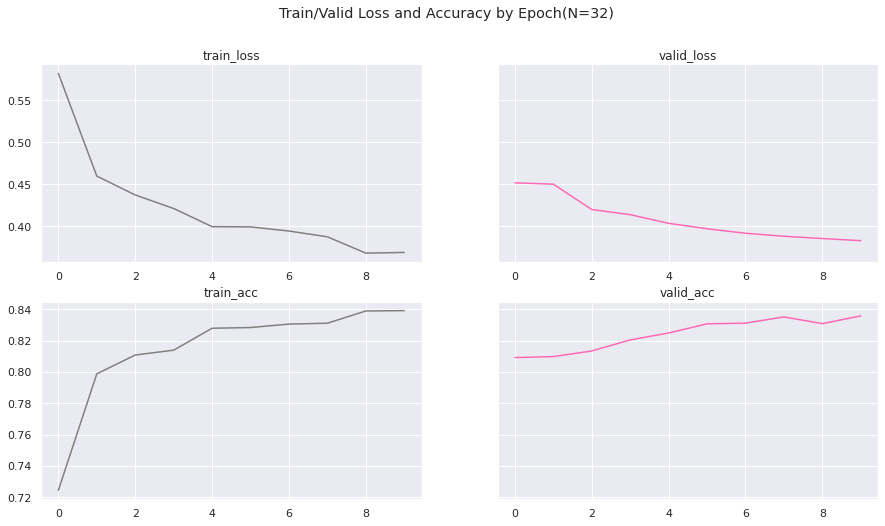

In [27]:
fig, axes = plt.subplots(2,2, figsize=(15,8), sharey='row')
fig.suptitle(f'Train/Valid Loss and Accuracy by Epoch(N={NUM_SENTENCES})')

axes[0][0].plot(train_loss_history.mean(axis=1),color='grey',)
axes[0][0].set_title('train_loss')

axes[0][1].plot(valid_loss_history, color='hotpink')
axes[0][1].set_title('valid_loss')

axes[1][0].plot(train_acc_history.mean(axis=1), color='grey')
axes[1][0].set_title('train_acc')

axes[1][1].plot(valid_acc_history, color='hotpink')
axes[1][1].set_title('valid_acc')


In [ ]:
model64 = torch.load('/content/drive/MyDrive/kaggle_clickbait/ClickBait_N64_BS1024_EPOCH10.pt')

In [ ]:
model64

In [ ]:
test_acc, test_loss = evaluate(model64, test_dataloader, 'test')

In [ ]:
test_acc, test_loss